In [1]:
import os
import sys
import scipy
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from PIL import Image
import numpy as np
import pprint
from utils_vgg import *

In [2]:
c_img = "lboro.jpg"
s_img = "starry_night.jpg"

In [3]:
model = load_vgg_model("data/imagenet-vgg-verydeep-19.mat")

### COMPUTING THE CONTENT COST

Let $a^{(G)}$ be the corresponding hidden layer activation. We will define as the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

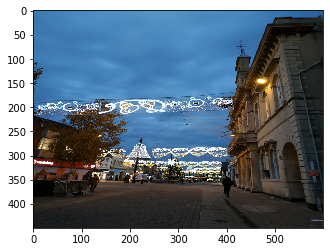

In [4]:
import imageio
img = imageio.imread(f"images/{c_img}")
plt.imshow(img)

In [5]:
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H*n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H*n_W, n_C])
    
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) / (4 * n_H * n_W * n_C)
    
    return J_content

In [6]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 7.641023


### COMPUTING THE STYLE COST

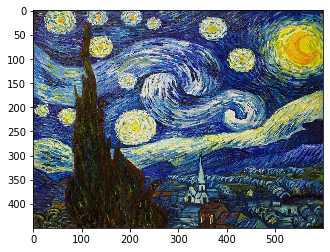

In [7]:
style_img = imageio.imread(f"images/{s_img}")
plt.imshow(style_img)

### STYLE MATRIX

In [8]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [9]:
tf.reset_default_graph()

with tf.Session() as test:
    A = tf.random_normal([3, 2], mean=1, stddev=4)
    GA = gram_matrix(A)

    print("GA = \n" + str(GA.eval()))

GA = 
[[37.160446 38.69546  47.02366 ]
 [38.69546  74.135414 58.38694 ]
 [47.02366  58.38694  62.127373]]


### STYLE COST

The goal is to minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$, abd the corresponding style cost for this layer is defined as:

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where  $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.

In [10]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(a_S, [n_H * n_W, n_C])
    a_G = tf.reshape(a_G, [n_H * n_W, n_C])    
    
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))
    
    J_style_layer = tf.reduce_sum((GS - GG)**2) / (4 * n_C**2 * (n_W * n_H)**2)
    
    return J_style_layer

In [11]:
tf.reset_default_graph()

with tf.Session() as test:
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)

    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 13.143171


### STYLE WEIGHTS

In [12]:
STYLE_LAYERS = [
                ("conv1_1", 0.2),
                ("conv2_1", 0.2),
                ("conv3_1", 0.2),
                ("conv4_1", 0.2),
                ("conv5_1", 0.2)]

Style cost for different layers:
$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

In [13]:
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0
    
    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        
        a_S = sess.run(out)
        a_G = out
        
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        
        J_style += coeff * J_style_layer
        
    return J_style

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [14]:
def total_cost(J_content, J_style, alpha=10, beta=40):
    J = alpha * J_content + beta * J_style
    return J

In [15]:
tf.reset_default_graph()

with tf.Session() as test:
    J_content = np.random.randn()
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = -27.57919467836153


### SOLVING THE OPTIMIZATION PROBLEM

In [16]:
img = imageio.imread(f"images/{c_img}")
img = reshape_and_normalize_img(img)

In [17]:
style_img = imageio.imread(f"images/{s_img}")
style_img = reshape_and_normalize_img(style_img)

In [24]:
def generate_noise_img(content_img, noise_ratio=0.6):
	noise_img = np.random.uniform(-20, 20, (1, 450, 600, 3)).astype('float32')
	input_img = noise_img * noise_ratio + content_img * (1 - noise_ratio)
	return input_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


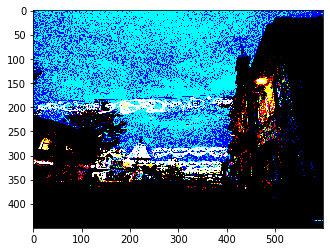

In [25]:
generated_img = generate_noise_img(img)
plt.imshow(generated_img[0])

In [26]:
model = load_vgg_model("data/imagenet-vgg-verydeep-19.mat")

In [27]:
def model_nn(sess, input_img, num_iters=400):
    sess.run(tf.global_variables_initializer())
    
    sess.run(model["input"].assign(input_img))
    
    for i in range(num_iters):
        sess.run(train_step)
        generated_img = sess.run(model["input"])
        
        if i % 20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            
            print("Interation " + str(i) + ":")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))            
            print("style cost = " + str(Js))            
            
            save_img("output/" + str(i) + ".png", generated_img)
    
    save_img("output/generated_img.jpg", generated_img)
    
    return generated_img

In [28]:
def save_img(path, img):
	means = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
	img = img + means

	img = np.clip(img[0], 0, 255).astype("uint8")
	imageio.imwrite(path, img)

In [29]:
tf.reset_default_graph()

with tf.Session() as sess:
    model = load_vgg_model("data/imagenet-vgg-verydeep-19.mat")
    sess.run(model['input'].assign(img))
    out = model["conv4_2"]
    
    a_C = sess.run(out)
    a_G = out

    J_content = compute_content_cost(a_C, a_G)
    
    J_style = compute_style_cost(model, STYLE_LAYERS)    
    
    J = total_cost(J_content, J_style, alpha=10, beta=40)
    optimizer = tf.train.AdamOptimizer(2.0)
    
    train_step = optimizer.minimize(J)
    
    model_nn(sess, generated_img)

Interation 0:
total cost = 3794154000.0
content cost = 8188.5894
style cost = 94851800.0
Interation 20:
total cost = 675735000.0
content cost = 9528.393
style cost = 16890992.0
Interation 40:
total cost = 318529730.0
content cost = 9365.309
style cost = 7960901.5
Interation 60:
total cost = 191729800.0
content cost = 9014.659
style cost = 4790991.0
Interation 80:
total cost = 131894320.0
content cost = 8692.102
style cost = 3295185.0
Interation 100:
total cost = 95153590.0
content cost = 8396.008
style cost = 2376740.8
Interation 120:
total cost = 69640680.0
content cost = 8115.179
style cost = 1738988.1
Interation 140:
total cost = 51231040.0
content cost = 7860.3115
style cost = 1278810.9
Interation 160:
total cost = 38321908.0
content cost = 7631.3857
style cost = 956139.94
Interation 180:
total cost = 29488326.0
content cost = 7417.5103
style cost = 735353.75
Interation 200:
total cost = 23470956.0
content cost = 7223.231
style cost = 584968.1
Interation 220:
total cost = 19289044.